In [43]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [44]:
import vcf

%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from pylab import plot, show, savefig, xlim, figure, hold, ylim, legend, boxplot, setp, axes
from itertools import compress
from pylab import MaxNLocator
import seaborn as sns; sns.set()
from matplotlib.colors import LogNorm
from matplotlib import gridspec
from matplotlib.gridspec import GridSpec
import ast
import itertools
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import fastcluster
from sklearn import cluster, datasets
import scipy.cluster.hierarchy as hier
from sklearn.cluster import KMeans
import time
import sys

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC

from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
import itertools

import networkx as nx
import scipy
import pickle
from collections import Counter

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

### Load Sample Annotation and SNPs called in each Sample

Sample Annotation

In [45]:
sample_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/dennis_mujuni_collaboration/annotation CSV files/sample_annotation.csv' , sep  = ',').set_index('tag')

In [46]:
sample_annotation.head()

,sample_id,sample_num,fastq_files,coverage,lineage_call
tag,,,,,
S0,Undetermined,0,/n/data1/hms/dbmi/farhat/Roger/dennis_mujuni_c...,25.5521,4.6.1.2
S1,TC100810,1,/n/data1/hms/dbmi/farhat/Roger/dennis_mujuni_c...,151.0760,4.9
S2,TC94815,2,/n/data1/hms/dbmi/farhat/Roger/dennis_mujuni_c...,60.5541,4.3.4.2.1
S3,TC101527,3,/n/data1/hms/dbmi/farhat/Roger/dennis_mujuni_c...,70.5301,3
S4,LB95669,4,/n/data1/hms/dbmi/farhat/Roger/dennis_mujuni_c...,82.3331,2.2.1


In [47]:
np.shape(sample_annotation)

(24, 5)

SNPs called across all Samples

In [48]:
SNPs_from_all_samples_df = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/dennis_mujuni_collaboration/variant_calls/SNPs/SNP_calls_across_all_samples.pkl')

In [49]:
SNPs_from_all_samples_df.head()

,ref_base,alt_base,ref_position,alt_AF,depth,tag,gene_id,gene_coord,gene_category,gene_symbol,SNP_ftype,AA_change
0,C,A,1849,0.38,59,S0,Rv0001_Rv0002,None,None,None,I,None
1,A,G,1977,0.90,50,S0,Rv0001_Rv0002,None,None,None,I,None
2,G,C,7362,0.93,26,S0,Rv0006,61,Antibiotic Resistance,gyrA,N,E21Q
3,G,C,7585,0.88,19,S0,Rv0006,284,Antibiotic Resistance,gyrA,N,S95T
4,T,C,9143,0.25,24,S0,Rv0006,1842,Antibiotic Resistance,gyrA,S,I614I


In [50]:
np.shape(SNPs_from_all_samples_df)

(24782, 12)

#### How many SNPs (alt AF $\ge 20\%$) were called in each sample?

In [51]:
num_SNPs_per_sample_series = pd.Series(Counter(SNPs_from_all_samples_df.tag))

#append to sample annotation 
sample_annotation.loc[:, 'num_SNPs'] = num_SNPs_per_sample_series[sample_annotation.index]

In [52]:
sample_annotation.loc[: , ['lineage_call','num_SNPs']].sort_values(by = 'num_SNPs')

,lineage_call,num_SNPs
tag,,
S1,4.9,53
S14,4.6.1.1,510
S2,4.3.4.2.1,611
S23,4.3.4.2.1,620
S9,4.4.1.1,627
S6,2.2,655
S16,3,908
S20,3.1.1,921
S4,2.2.1,975


#### How many SNPs (alt AF $\ge 90\%$) were called in each sample?

In [53]:
num_SNPs_per_sample_series = pd.Series(Counter(SNPs_from_all_samples_df[SNPs_from_all_samples_df.alt_AF >= 0.90].tag))

#append to sample annotation 
sample_annotation.loc[:, 'num_fSNPs'] = num_SNPs_per_sample_series[sample_annotation.index]

In [54]:
sample_annotation.loc[: , ['lineage_call','num_SNPs','num_fSNPs']].sort_values(by = 'num_fSNPs')

,lineage_call,num_SNPs,num_fSNPs
tag,,,
S1,4.9,53,45
S0,4.6.1.2,1123,162
S13,4.6.1.1,1301,337
S24,4.2.2,1853,394
S7,4.6.1.2,1960,469
S14,4.6.1.1,510,506
S23,4.3.4.2.1,620,563
S2,4.3.4.2.1,611,595
S6,2.2,655,596


The genetic distance (based off of fixed SNPs with alternate allele frequency $\ge 90\%$) between these isolates and H37Rv (lineage 4.10) looks accurate!

### How many different unique SNPs were called?

#### Append a column that contains a unique mutation key (H37Rv Reference Position + Alternate Allele)

In [55]:
mutation_key_list = [str(ref_pos_i) + '_' + alt_base_i for ref_pos_i , alt_base_i in zip( list(SNPs_from_all_samples_df.ref_position) , list(SNPs_from_all_samples_df.alt_base) )]
SNPs_from_all_samples_df['mut_key'] = mutation_key_list

In [56]:
SNPs_from_all_samples_df.head()

,ref_base,alt_base,ref_position,alt_AF,depth,tag,gene_id,gene_coord,gene_category,gene_symbol,SNP_ftype,AA_change,mut_key
0,C,A,1849,0.38,59,S0,Rv0001_Rv0002,None,None,None,I,None,1849_A
1,A,G,1977,0.90,50,S0,Rv0001_Rv0002,None,None,None,I,None,1977_G
2,G,C,7362,0.93,26,S0,Rv0006,61,Antibiotic Resistance,gyrA,N,E21Q,7362_C
3,G,C,7585,0.88,19,S0,Rv0006,284,Antibiotic Resistance,gyrA,N,S95T,7585_C
4,T,C,9143,0.25,24,S0,Rv0006,1842,Antibiotic Resistance,gyrA,S,I614I,9143_C


In [57]:
num_samples_SNP_called = pd.Series(Counter(SNPs_from_all_samples_df.mut_key)).sort_values()

In [58]:
len(num_samples_SNP_called)

8172

There were **24,782** SNPs called across all **24** samples. There were **8,172** unique SNPs

In [59]:
num_samples_SNP_called.head()

100010_A     1
3405776_G    1
3405132_T    1
3401501_A    1
3398914_G    1
dtype: int64

In [60]:
num_samples_SNP_called.tail()

2251999_G    23
1933988_A    23
265554_C     23
1471659_T    24
459399_C     24
dtype: int64

### SNP Frequency Spectrum

How many SNPs (mutations) are present in 1 isolate, 2 isolates, 3 isolates, ... , 24 isolates?

In [61]:
pd.Series(Counter(num_samples_SNP_called))

1     5002
2     1136
3      434
4      262
5      262
6       81
7       74
8       83
9       95
10     108
11      75
12      53
13      54
14      52
15      46
16      61
17      59
18      66
19      36
20      41
21      44
22      37
23       9
24       2
dtype: int64

### Distribution of Alternate Allele Frequencies for all SNPs called

In [63]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=3
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 12})

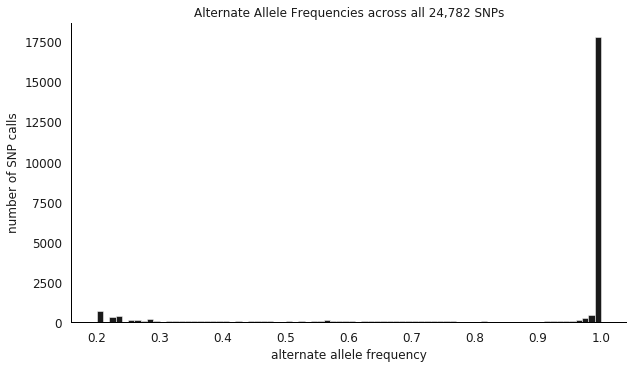

In [70]:
fig , ax = plt.subplots()

#SNP found in isolate denoted with a '1', sum across columns (isolates)
n , bins , patches = plt.hist(SNPs_from_all_samples_df.alt_AF , bins = 80 , color = 'k' , rwidth = 1.0 , edgecolor='white', linewidth=0.5)

plt.title('Alternate Allele Frequencies across all 24,782 SNPs', fontsize = 12, color = 'k')
plt.xlabel('alternate allele frequency', fontsize = 12, color = 'k')
plt.ylabel('number of SNP calls' , fontsize = 12, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)

ax.tick_params(labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(9.0, 5.25)
fig.tight_layout()

plt.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
plt.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

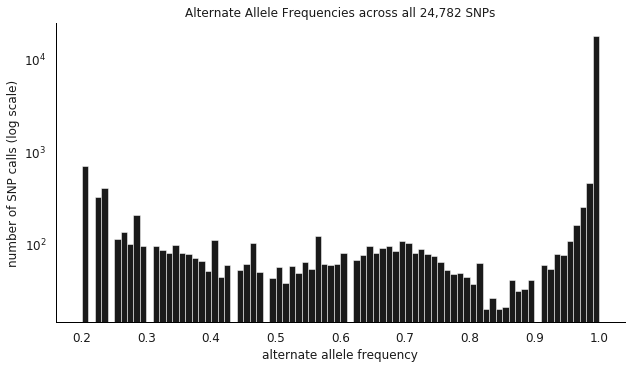

In [78]:
fig , ax = plt.subplots()

#SNP found in isolate denoted with a '1', sum across columns (isolates)
n , bins , patches = plt.hist(SNPs_from_all_samples_df.alt_AF , bins = 80 , color = 'k' , rwidth = 1.0 , edgecolor='white', linewidth=0.5)

plt.title('Alternate Allele Frequencies across all 24,782 SNPs', fontsize = 12, color = 'k')
plt.xlabel('alternate allele frequency', fontsize = 12, color = 'k')
plt.ylabel('number of SNP calls (log scale)' , fontsize = 12, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
ax.set_yscale('log')

ax.tick_params(labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(9.0, 5.25)
fig.tight_layout()

plt.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
plt.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()